Topic analysis

Now lets analyse a bit the main topics of our data set


Imports

In [77]:
%store -r game_df_cleaned
%store -r swords_df_cleaned

%store -r game_text_cleaned
%store -r swords_text_cleaned

In [49]:
# !pip install textacy
# !python -m spacy download en_core_web_lg
# !pip install seaborn
# !pip install pyLDAvis
# !pip install gensim

In [51]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from collections import Counter #for counting
import seaborn as sns #for visualization
from IPython.display import Markdown, display
from siuba import *
import pyLDAvis.gensim_models
import gensim
import re
import nltk

plt.style.use('seaborn')
sns.set(font_scale=2)
nlp = spacy.load('en_core_web_lg')
nlp.max_length = 5000000

C:\University\year3\Sem2\DM\Project\Data-Mining\venv\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
C:\University\year3\Sem2\DM\Project\Data-Mining\venv\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\University\year3\Sem2\DM\Project\Data-Mining\venv\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [4]:
def text_cleaned_to_string(text: list) -> str:
    res = ""
    for l_ in text:
        for word in l_:
            res += word + " "
    return res

In [30]:

def analyze_topics(text: list):
    text_string = text_cleaned_to_string(text)
    doc = nlp(text_string)

    topics = []
    for token in doc:
        if (not token.is_stop) and (token.pos_ == "NOUN") and (len(str(token))>2):
            topics.append(token)

    topics = [str(x) for x in topics]

    df_nouns = pd.DataFrame(topics, columns=["Topics"])
    df_nouns
    plt.figure(figsize=(7,6))
    sns.countplot(y="Topics",
                 data=df_nouns,
                 order=df_nouns["Topics"].value_counts().iloc[:15].index)
    plt.show()

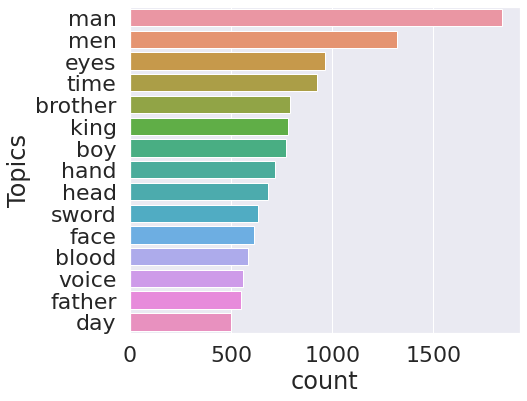

In [31]:
analyze_topics(game_text_cleaned)

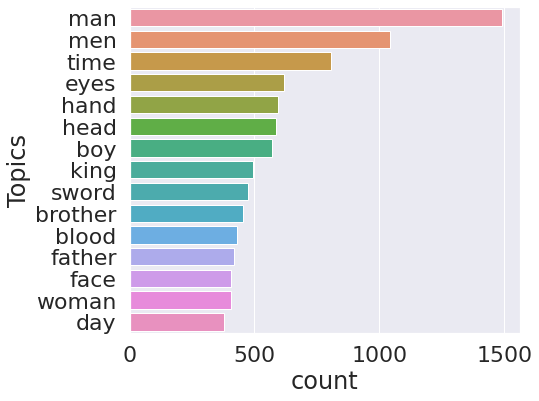

In [32]:
analyze_topics(swords_text_cleaned)

In [24]:
def get_characters(text: list):
    text_string = text_cleaned_to_string(text)
    doc = nlp(text_string)

    characters = []
    for ent in doc.ents:
        if ent.label_ in ["PERSON"]:
            characters.append(ent.text.strip())

#     characters = [str(x) for x in characters]

    df_nouns = pd.DataFrame(characters, columns=["Main Characters"])
    df_nouns = df_nouns[~df_nouns["Main Characters"].str.contains(']')]
    return df_nouns

def get_character_string(text: list):
    characters = get_characters(text)
    character_list = []
    for x in characters['Main Characters']:
        character_list.append(x)

    df = pd.DataFrame(character_list, columns=["Characters"])
    df = df[~df["Characters"].str.contains(' ')]
    return  df

def main_characters(text: list):

    df_nouns = get_characters(text)
    plt.figure(figsize=(7,6))
    sns.countplot(y="Main Characters",
                 data=df_nouns,
                 order=df_nouns["Main Characters"].value_counts().iloc[:10].index)
    plt.show()

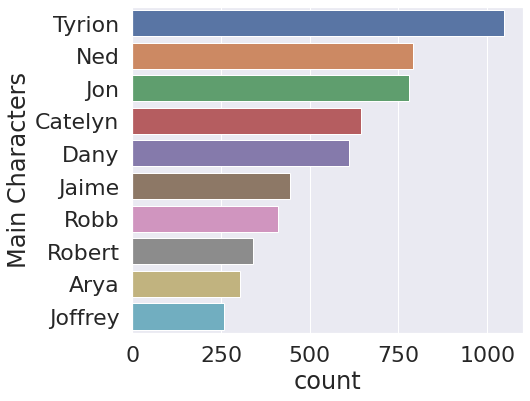

In [34]:
main_characters(game_text_cleaned)

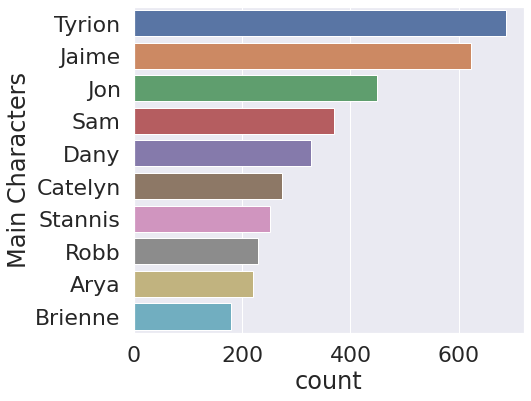

In [35]:
main_characters(swords_text_cleaned)

In [36]:
def time_analysis(text: list):
    text_string = text_cleaned_to_string(text)
    doc = nlp(text_string)

    time = []
    for ent in doc.ents:
        if ent.label_ in ["DATE"]:
            time.append(ent.text.strip())

    time = [str(x) for x in time]

    df_nouns = pd.DataFrame(time, columns=["Time"])
    plt.figure(figsize=(7,6))
    sns.countplot(y="Time",
                 data=df_nouns,
                 order=df_nouns["Time"].value_counts().iloc[:15].index)
    plt.show()

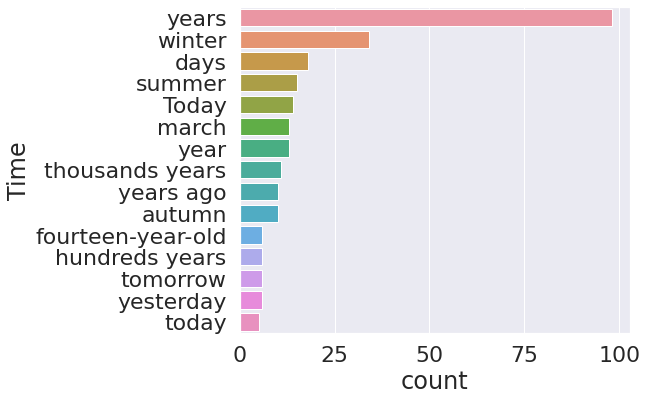

In [37]:
time_analysis(game_text_cleaned)

In [ ]:
time_analysis(swords_text_cleaned)

In [25]:
chars_game = get_character_string(game_text_cleaned)
chars_game_filtered = count(chars_game, _.Characters, ascending=False)
chars_game_filtered = chars_game_filtered.sort_values(by='n', ascending=False)
chars_game_filtered = chars_game_filtered.drop(columns='ascending')

chars_swords = get_character_string(swords_text_cleaned)
chars_swords_filtered = count(chars_swords, _.Characters, ascending=False)
chars_swords_filtered = chars_swords_filtered.sort_values(by='n', ascending=False)
chars_swords_filtered = chars_swords_filtered.drop(columns='ascending')

In [26]:
chars_swords_filtered.head(50)

,Characters,n
476,Tyrion,686
218,Jaime,622
231,Jon,448
413,Sam,370
92,Dany,328
70,Catelyn,274
437,Stannis,252
390,Robb,230
21,Arya,220
54,Brienne,180


In [27]:
chars_game_filtered.head(50)

,Characters,n
571,Tyrion,1049
407,Ned,791
275,Jon,780
87,Catelyn,645
115,Dany,612
259,Jaime,445
472,Robb,411
473,Robert,341
25,Arya,304
272,Joffrey,259


In [22]:
def deaths_analysis(characters : pd.DataFrame, df1 : pd.DataFrame, df2 : pd.DataFrame):

    deaths = characters.copy()
    deaths = deaths.assign(dead = 'False')
    deaths = deaths.drop_duplicates(subset=['Characters'], ignore_index=True)

    for x in df1['Characters']:
        remained = False
        for y in df2['Characters']:
            if x == y:
                remained = True
                cnt1 = df1[df1['Characters'] == x]['n'].values[0]
                cnt2 = df2[df2['Characters'] == y]['n'].values[0]
                if cnt1/cnt2 >= 2.5:
                    deaths.loc[deaths['Characters'] == x, 'dead'] = 'True'
        if remained == False:
            deaths.loc[deaths['Characters'] == x, 'dead'] = 'True'

    return deaths


In [48]:
dead_df = deaths_analysis(chars_game_filtered[:50], chars_game_filtered, chars_swords_filtered)
dead_df.head(50)

,Characters,n,dead
0,Tyrion,1049,False
1,Ned,791,True
2,Jon,780,False
3,Catelyn,645,False
4,Dany,612,False
5,Jaime,445,False
6,Robb,411,False
7,Robert,341,True
8,Arya,304,False
9,Joffrey,259,False


In [100]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))


stemmer = WordNetLemmatizer()
stop_words = ['chapter']
def preprocess_text(df : pd.DataFrame):

        tokens = [stemmer.lemmatize(word) for word in df['word']]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if word not in stop_words]
        tokens = [word for word in tokens if len(word)  > 5]


        return tokens

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Iulia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Iulia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [105]:
from gensim import corpora
# nltk.download('omw-1.4')

authors_corpus = [game_df_cleaned [:1000] ,swords_df_cleaned[:1000] ]

processed_data = []
for doc in authors_corpus:
    tokens = preprocess_text(doc)
    processed_data.append(tokens)

gensim_dictionary = corpora.Dictionary(processed_data)
gensim_corpus = [gensim_dictionary.doc2bow(token, allow_update=True) for token in processed_data]

lda_model = gensim.models.ldamodel.LdaModel(gensim_corpus, num_topics=4, id2word=gensim_dictionary, passes=40)


In [106]:
lda_visualization = pyLDAvis.gensim_models.prepare(lda_model, gensim_corpus, gensim_dictionary, sort_topics=False)
pyLDAvis.display(lda_visualization)

C:\University\year3\Sem2\DM\Project\Data-Mining\venv\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
